In [1]:
import os
import cv2
import math
import time
import pickle
import numpy as np
from random import randint
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
Veh_Imgs_Path = "./../udacity_dataset/vehicles/vehicles/"
NonVeh_Imgs_Path = "./../udacity_dataset/non_vehicles/non_vehicles/"

Veh_Imgs = os.listdir(Veh_Imgs_Path)
NonVeh_Imgs = os.listdir(NonVeh_Imgs_Path)

In [3]:
def CollectImages(folderpath, ImagePaths, isLabeled = True):
    images = []
    for ImagePath in ImagePaths:
        if (len(ImagePath.split('.')) == 2):
            im = cv2.imread(folderpath + ImagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #print('Image ' , ImagePath , ' is: ', type(im), ' with dimensions: ', im.shape)
            if isLabeled == True:
                images.append((im, ImagePath.split('.')[0]))
            else:
                images.append(im)
        else:
            print('Image', ImagePath, 'is correupted --> Discarded.')

    return images

In [4]:
CarImageSet = []
NonCarImageSet = []

for folder in Veh_Imgs:
    folderpath = Veh_Imgs_Path + folder
    Carsimagespath = os.listdir(folderpath)
    CarImageSet.append(CollectImages(folderpath + '/', Carsimagespath, True))

for folder in NonVeh_Imgs:
    folderpath = NonVeh_Imgs_Path + folder
    NonCarsimagespath = os.listdir(folderpath)
    NonCarImageSet.append(CollectImages(folderpath + '/', NonCarsimagespath, True))

CarImageSet = np.concatenate(CarImageSet)
NonCarImageSet = np.concatenate(NonCarImageSet)

print('Car Image Set has ', str(len(CarImageSet)))
print('Non Car Image Set has ', str(len(NonCarImageSet)))

Car Image Set has  8792
Non Car Image Set has  8968


In [5]:
imgPxlVal = 0
img_Label = 1

In [6]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) <= (nrows * ncols)
    if labels != "":
        assert len(images) == len(labels)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        if labels != "":
            plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [7]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) <= (nrows * ncols)
    if labels != "":
        assert len(images) == len(labels)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        if labels != "":
            plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [8]:
def pltHistograms(hists, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, xlim = [0,256]):
    assert len(hists) == len(labels)
    assert len(hists) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(hists)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        plt.plot(hists[index])
        plt.xlim(xlim)
    
    plt.tight_layout()
    plt.show()

In [9]:
Channel_0 = 0
Channel_1 = 1
Channel_2 = 2

histSize = [48]
histrange = [0,255]

ColorSpace = ['RGB','HSV','HLS', 'LAB', 'YUV', 'LUV', 'YCrCb']

In [10]:
def ExploreColorSpaceHistogram(img):
    hist = []
    hist_label = []

    hist_0 = cv2.calcHist(img,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(img,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(img,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("RGB_Channel 0")
    hist.append(hist_1)
    hist_label.append("RGB_Channel 1")
    hist.append(hist_2)
    hist_label.append("RGB_Channel 2")

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hist_0 = cv2.calcHist(HSV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HSV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HSV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HSV_Channel 0")
    hist.append(hist_1)
    hist_label.append("HSV_Channel 1")
    hist.append(hist_2)
    hist_label.append("HSV_Channel 2")

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hist_0 = cv2.calcHist(HLS,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HLS,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HLS,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HLS_Channel 0")
    hist.append(hist_1)
    hist_label.append("HLS_Channel 1")
    hist.append(hist_2)
    hist_label.append("HLS_Channel 2")

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hist_0 = cv2.calcHist(LAB,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LAB,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LAB,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LAB_Channel 0")
    hist.append(hist_1)
    hist_label.append("LAB_Channel 1")
    hist.append(hist_2)
    hist_label.append("LAB_Channel 2")

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hist_0 = cv2.calcHist(YUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("YUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("YUV_Channel 2")

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hist_0 = cv2.calcHist(LUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("LUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("LUV_Channel 2")
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hist_0 = cv2.calcHist(YCrCb,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YCrCb,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YCrCb,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YCrCb_Channel 0")
    hist.append(hist_1)
    hist_label.append("YCrCb_Channel 1")
    hist.append(hist_2)
    hist_label.append("YCrCb_Channel 2")

    pltHistograms(hist, hist_label, 7, 3, xlim = [0, histSize[0]-1])

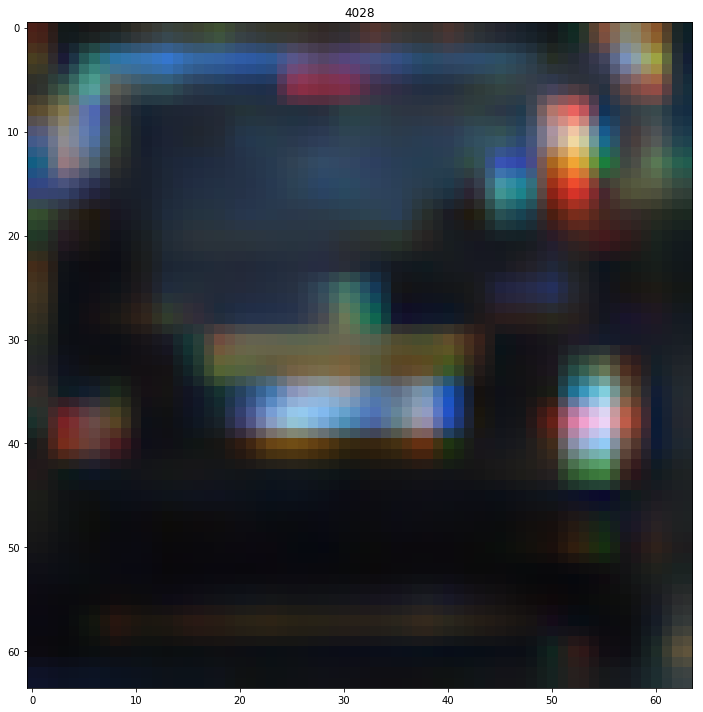

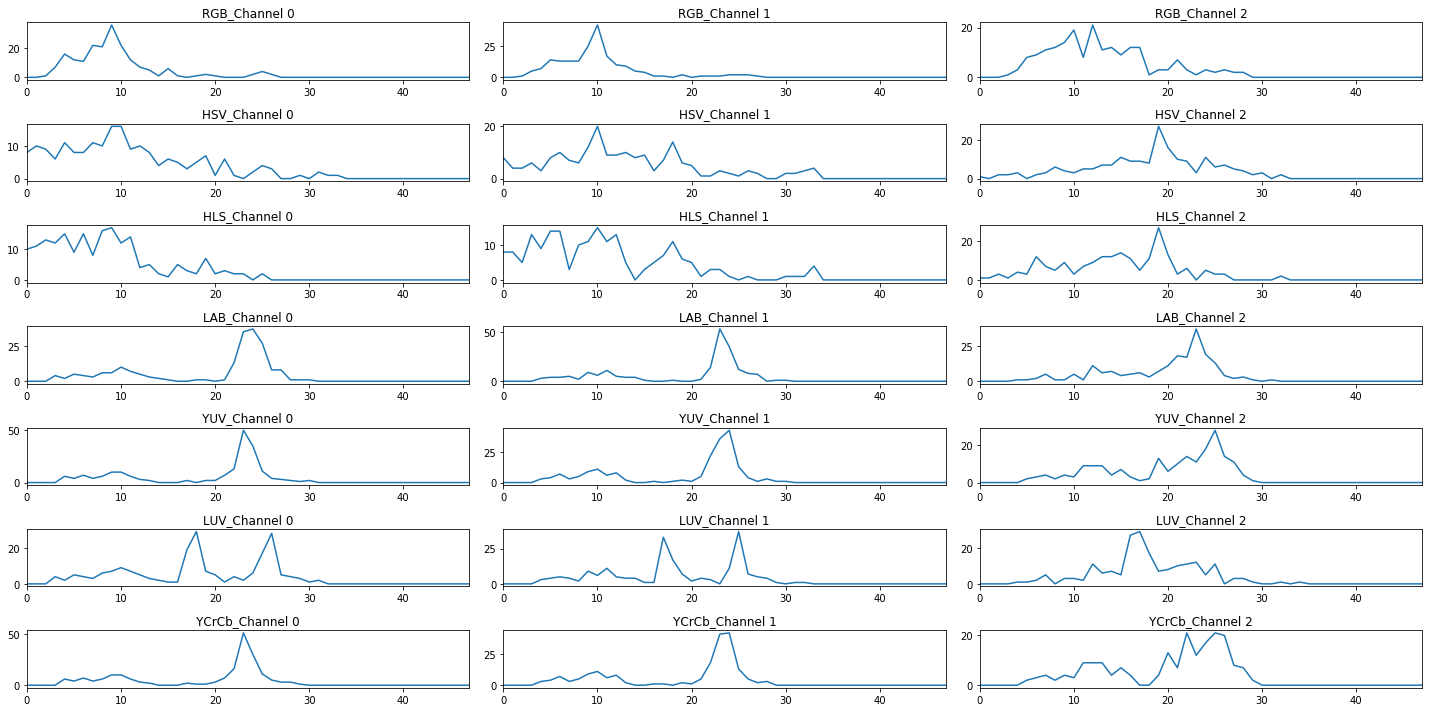

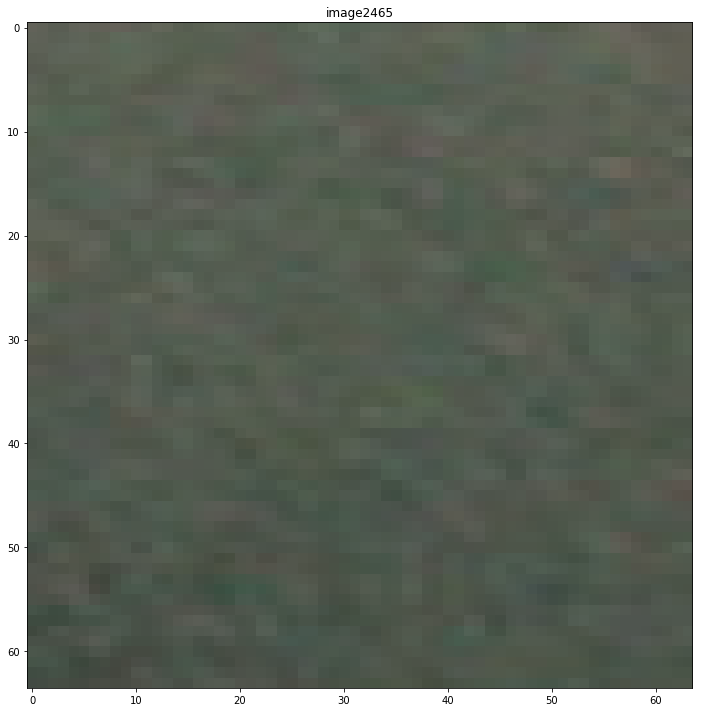

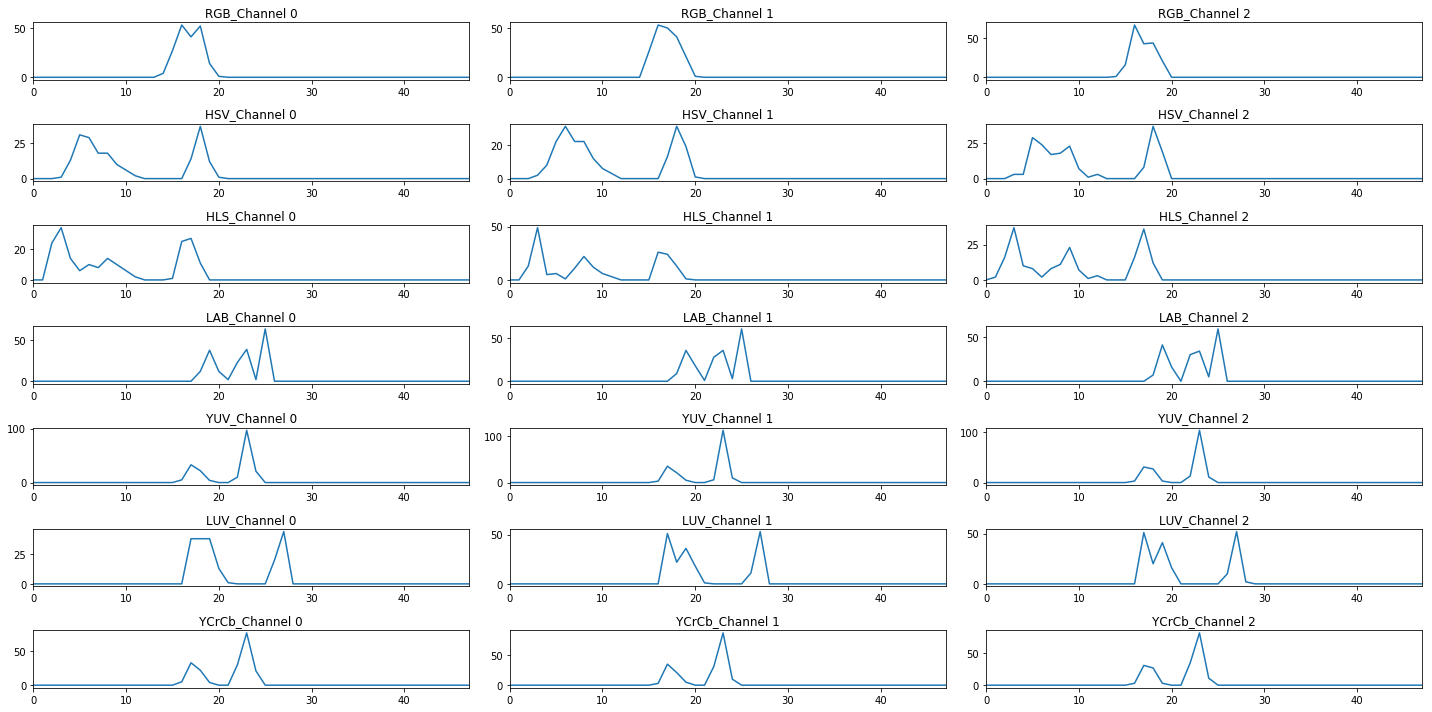

In [11]:
#CarImageIndex = 0
CarImageIndex = randint(0, len(CarImageSet))
CarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
CarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(CarImage, CarImageLabel, 1, 1)
ExploreColorSpaceHistogram(CarImage[0])

#NonCarImageIndex = 0
NonCarImageIndex = randint(0, len(NonCarImageSet))
NonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
NonCarImageLabel = [NonCarImageSet[NonCarImageIndex][img_Label]]

pltImages(NonCarImage, NonCarImageLabel, 1, 1)
ExploreColorSpaceHistogram(NonCarImage[0])

In [12]:
#Code obtained from Udacity lesson 16
def bin_spatial_Demo_colorspace(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [13]:
size=(8, 8)

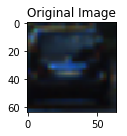

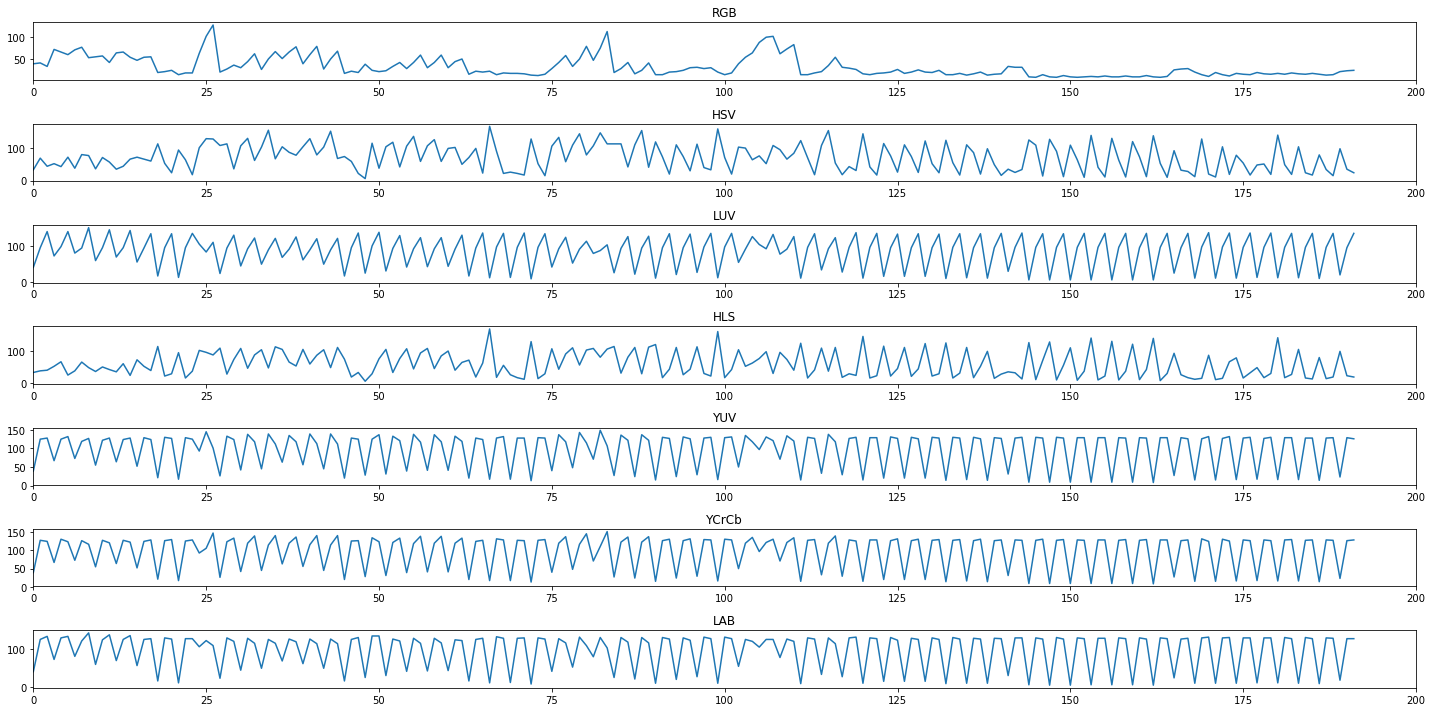

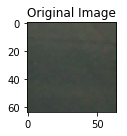

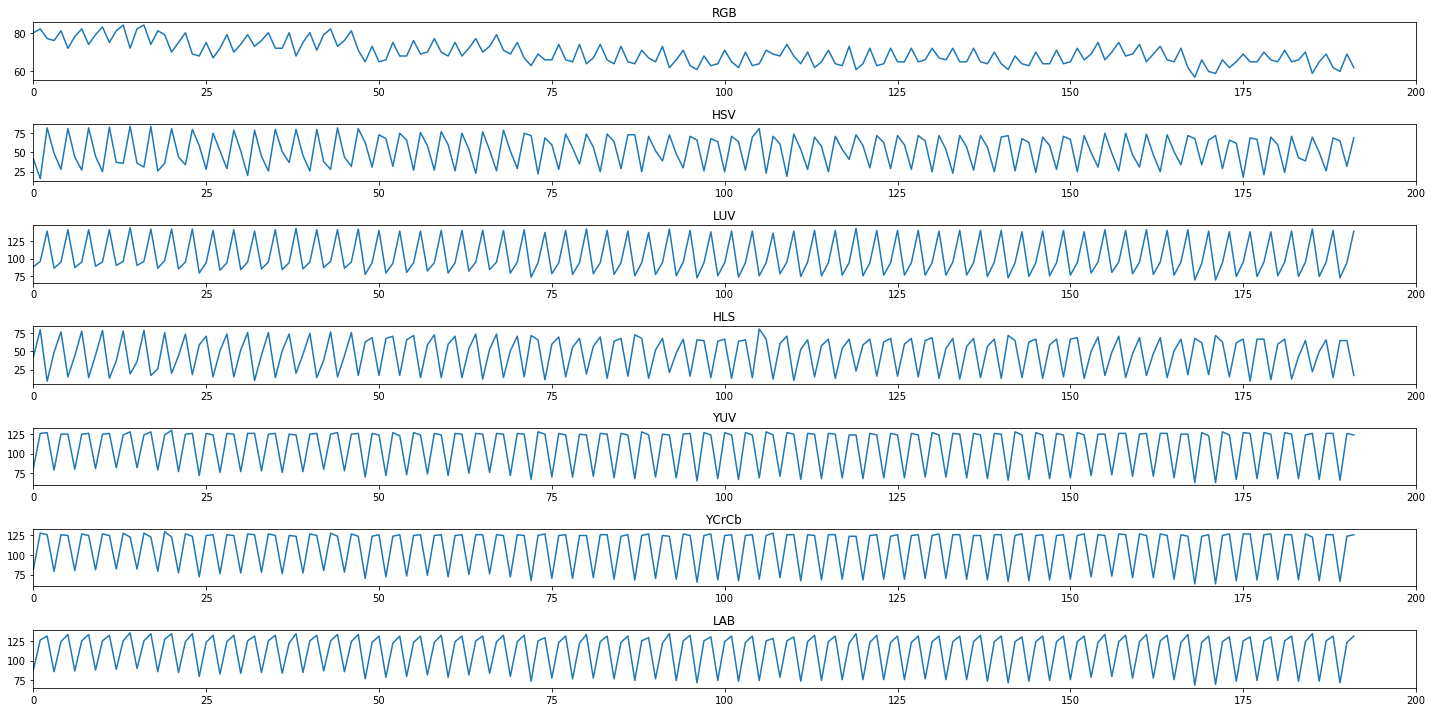

In [14]:
vis_imgs = []
vis_labels = []

index = randint(0, len(CarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([CarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 200])

vis_imgs = []
vis_labels = []

index = randint(0, len(NonCarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([NonCarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 200])

In [15]:
def get_hog_features_demo(img, orient, pix_per_cell, cell_per_block, blockNorm, trns_sqrt, visualize=False, feature_vec=True):
    if visualize == True:
        features, hog_im = hog(img,
                               orientations=orient,
                               pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block, cell_per_block),
                               block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                               transform_sqrt=trns_sqrt, 
                               visualise=visualize,
                               feature_vector=feature_vec)
        return features, hog_im
    else:      
        features = hog(img,
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                       transform_sqrt=trns_sqrt, 
                       visualise=visualize,
                       feature_vector=feature_vec)
        return features

In [16]:
orient = 8
pix_per_cell = 16
cells_per_block = 2
TransformSqrt = True

blockNorm = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']

hc = 'ALL'

In [17]:
def VisauliseHOG(img):
    vis = True
    __, hog_im = get_hog_features_demo(
        img,
        orient,
        pix_per_cell,
        cells_per_block,
        'L2-Hys',
        visualize=vis,
        trns_sqrt=TransformSqrt,
        feature_vec=False)
    return hog_im

In [18]:
def ExploreHOGSpace(img):
    HOG_IMs = []
    hog_label = []
    
    hog_0 = VisauliseHOG(img[:,:,Channel_0])
    hog_1 = VisauliseHOG(img[:,:,Channel_1])
    hog_2 = VisauliseHOG(img[:,:,Channel_2])
    pltImages([hog_0], ["RGB_Channel 0"], 1, 1)
    pltImages([hog_1], ["RGB_Channel 1"], 1, 1)
    pltImages([hog_2], ["RGB_Channel 2"], 1, 1)

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hog_0 = VisauliseHOG(HSV[:,:,Channel_0])
    hog_1 = VisauliseHOG(HSV[:,:,Channel_1])
    hog_2 = VisauliseHOG(HSV[:,:,Channel_2])
    pltImages([hog_0], ["HSV_Channel 0"], 1, 1)
    pltImages([hog_1], ["HSV_Channel 1"], 1, 1)
    pltImages([hog_2], ["HSV_Channel 2"], 1, 1)

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hog_0 = VisauliseHOG(HLS[:,:,Channel_0])
    hog_1 = VisauliseHOG(HLS[:,:,Channel_1])
    hog_2 = VisauliseHOG(HLS[:,:,Channel_2])
    pltImages([hog_0], ["HLS_Channel 0"], 1, 1)
    pltImages([hog_1], ["HLS_Channel 1"], 1, 1)
    pltImages([hog_2], ["HLS_Channel 2"], 1, 1)

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hog_0 = VisauliseHOG(LAB[:,:,Channel_0])
    hog_1 = VisauliseHOG(LAB[:,:,Channel_1])
    hog_2 = VisauliseHOG(LAB[:,:,Channel_2])
    pltImages([hog_0], ["LAB_Channel 0"], 1, 1)
    pltImages([hog_1], ["LAB_Channel 1"], 1, 1)
    pltImages([hog_2], ["LAB_Channel 2"], 1, 1)

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hog_0 = VisauliseHOG(YUV[:,:,Channel_0])
    hog_1 = VisauliseHOG(YUV[:,:,Channel_1])
    hog_2 = VisauliseHOG(YUV[:,:,Channel_2])
    pltImages([hog_0], ["YUV_Channel 0"], 1, 1)
    pltImages([hog_1], ["YUV_Channel 1"], 1, 1)
    pltImages([hog_2], ["YUV_Channel 2"], 1, 1)

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hog_0 = VisauliseHOG(LUV[:,:,Channel_0])
    hog_1 = VisauliseHOG(LUV[:,:,Channel_1])
    hog_2 = VisauliseHOG(LUV[:,:,Channel_2])
    pltImages([hog_0], ["LUV_Channel 0"], 1, 1)
    pltImages([hog_1], ["LUV_Channel 1"], 1, 1)
    pltImages([hog_2], ["LUV_Channel 2"], 1, 1)
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hog_0 = VisauliseHOG(YCrCb[:,:,Channel_0])
    hog_1 = VisauliseHOG(YCrCb[:,:,Channel_1])
    hog_2 = VisauliseHOG(YCrCb[:,:,Channel_2])
    pltImages([hog_0], ["YCrCb_Channel 0"], 1, 1)
    pltImages([hog_1], ["YCrCb_Channel 1"], 1, 1)
    pltImages([hog_2], ["YCrCb_Channel 2"], 1, 1)

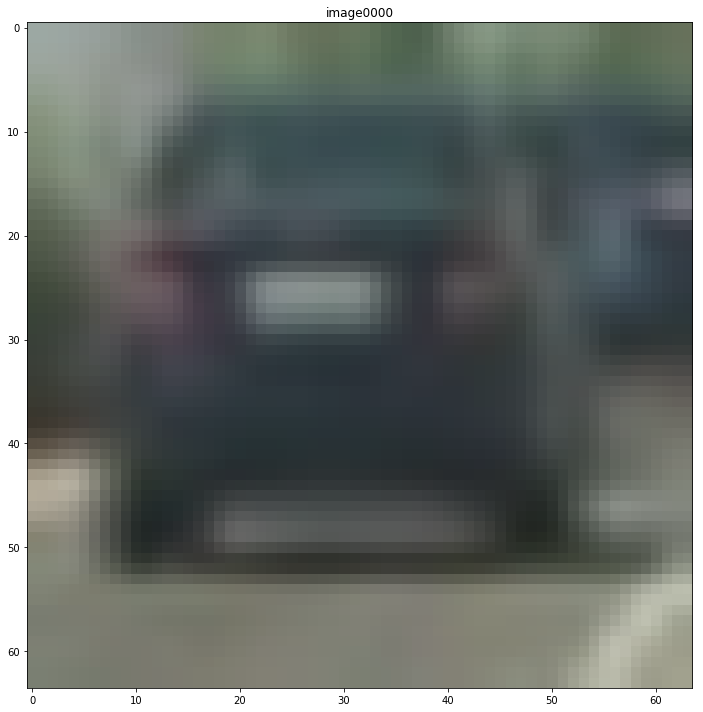

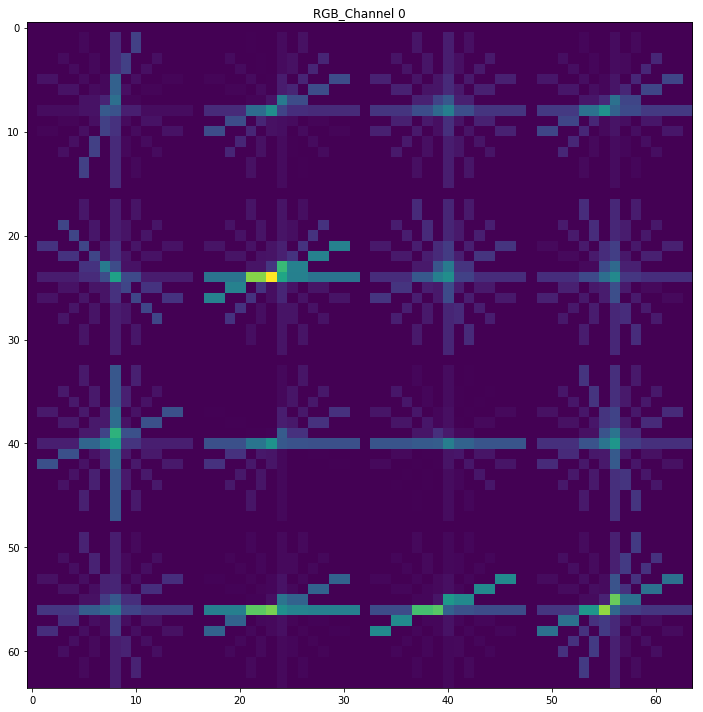

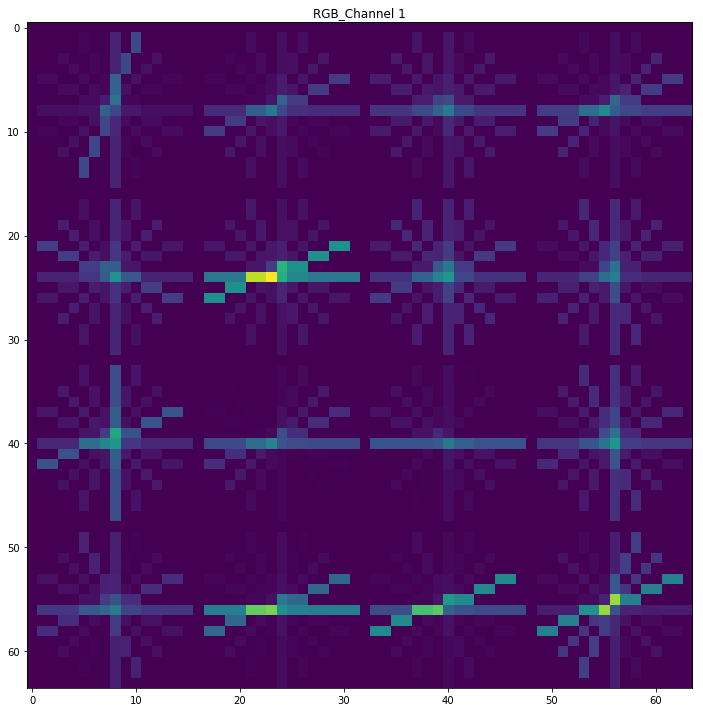

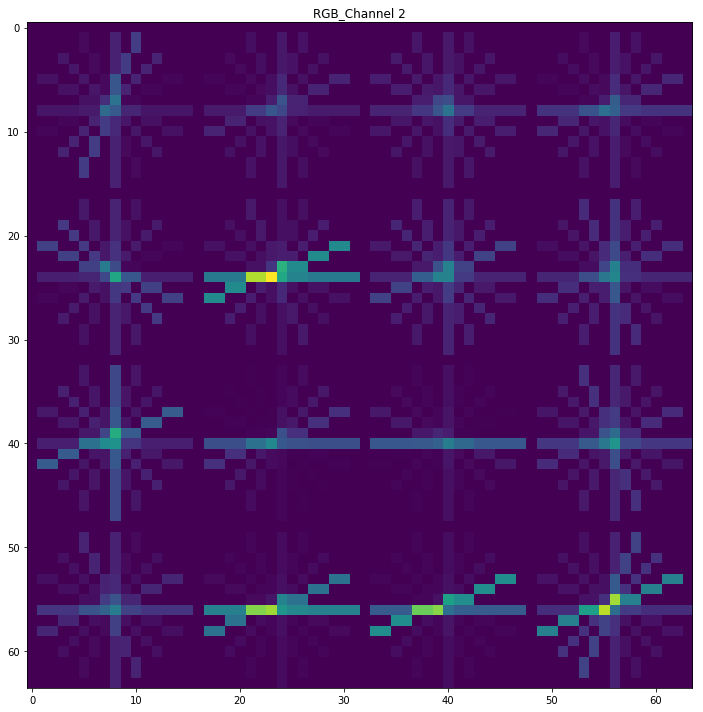

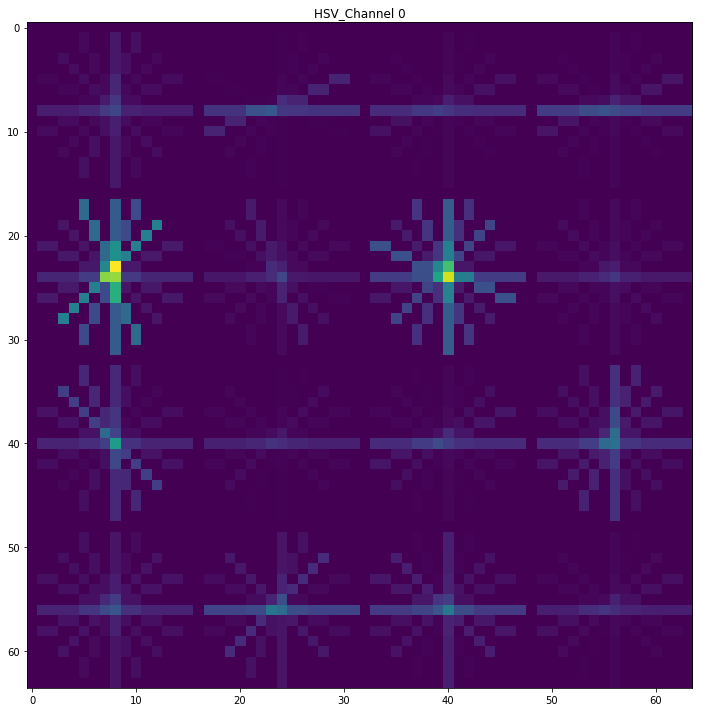

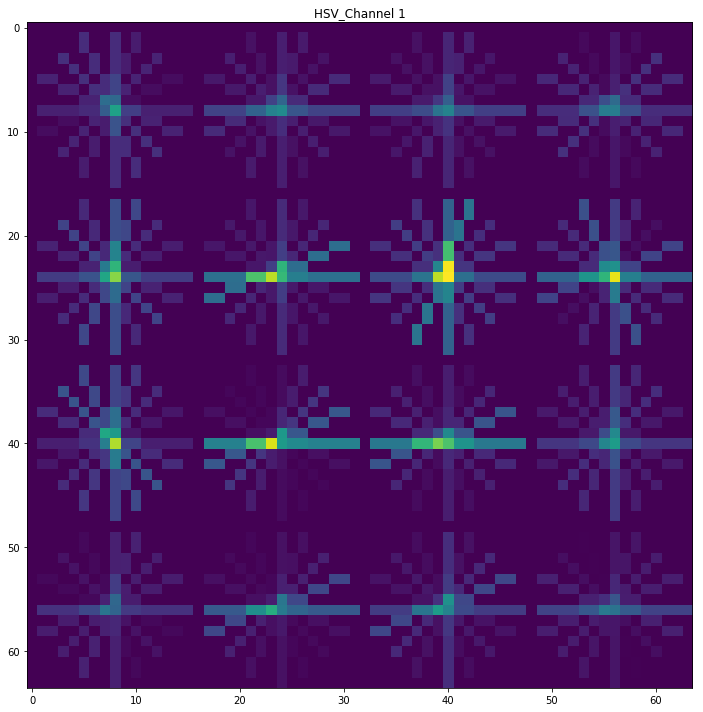

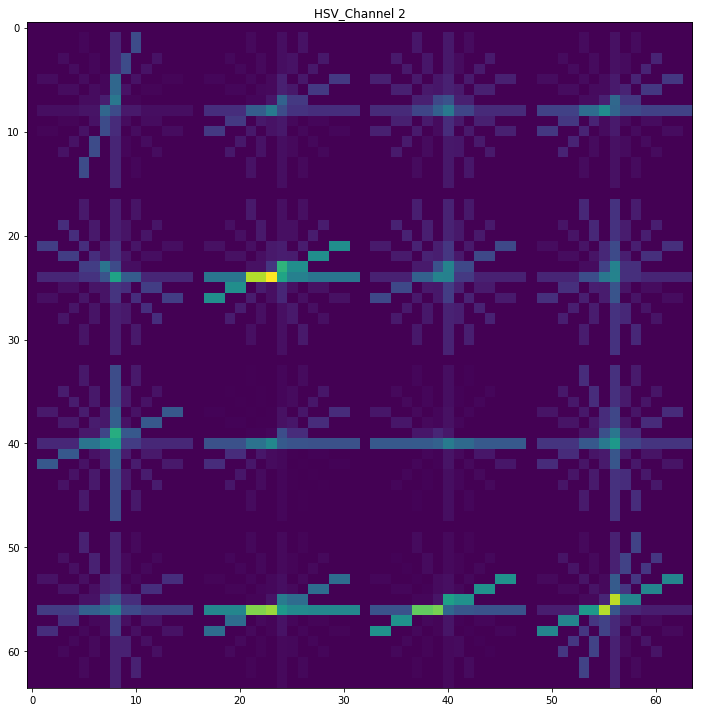

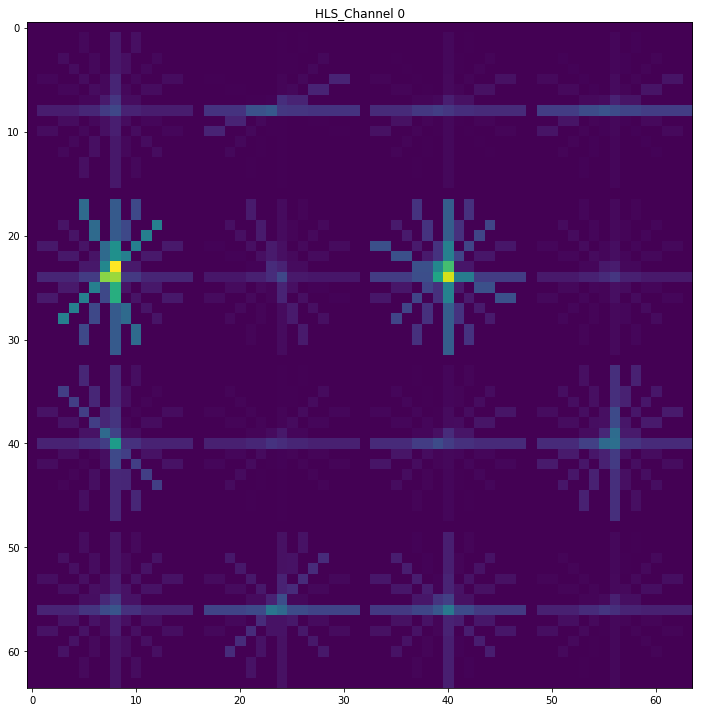

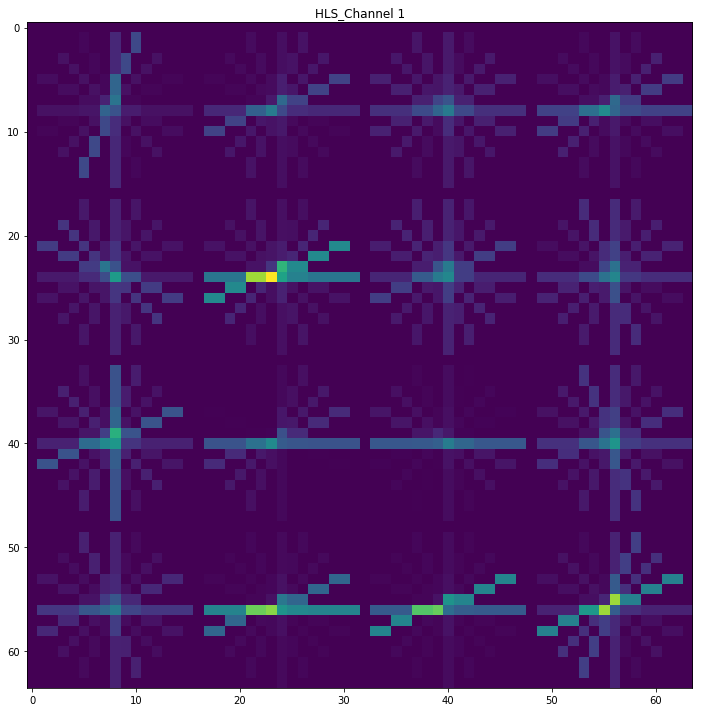

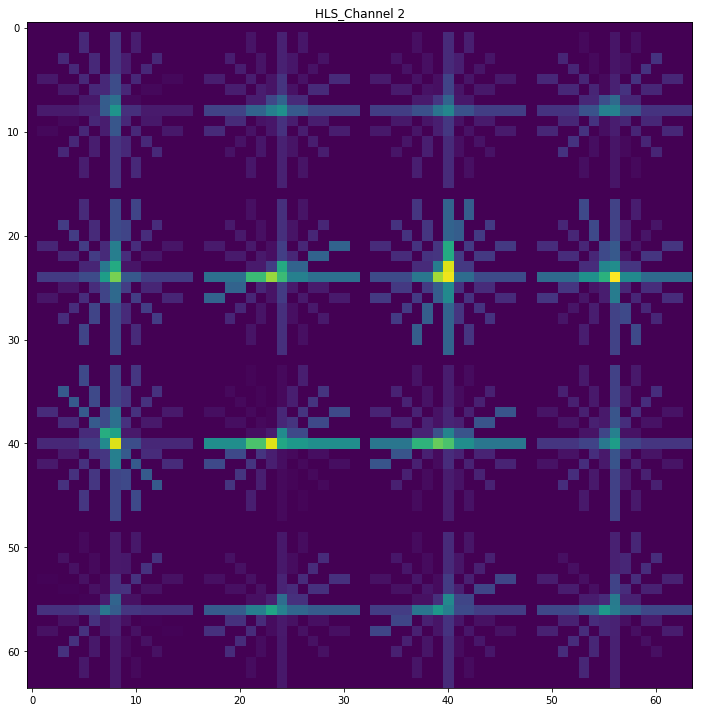

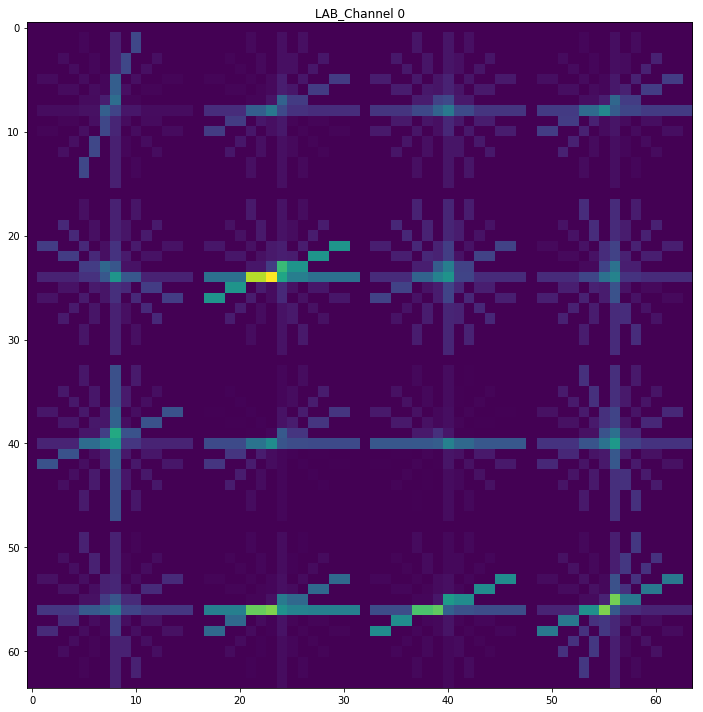

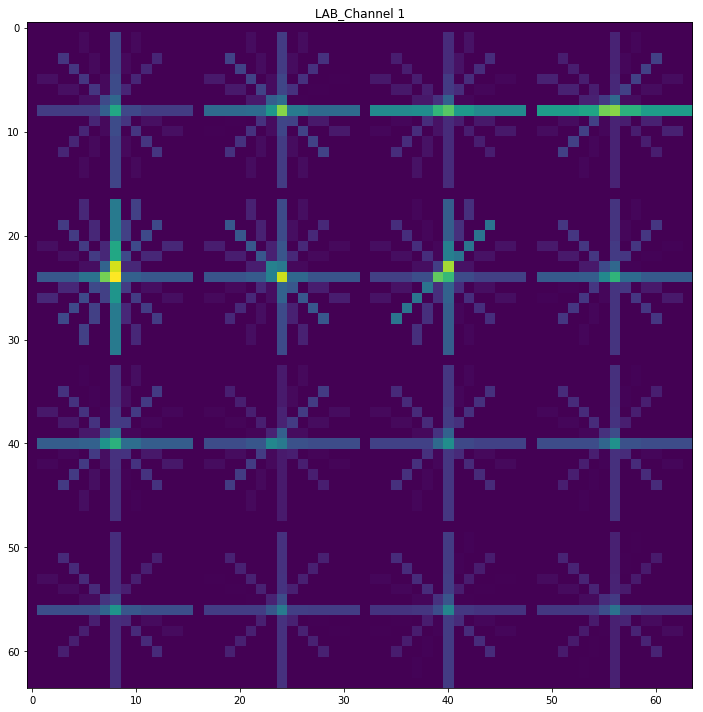

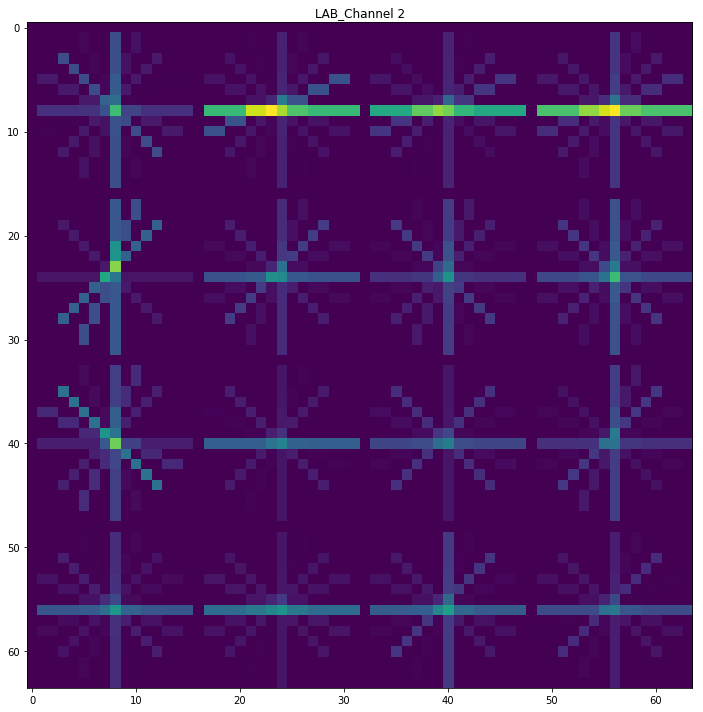

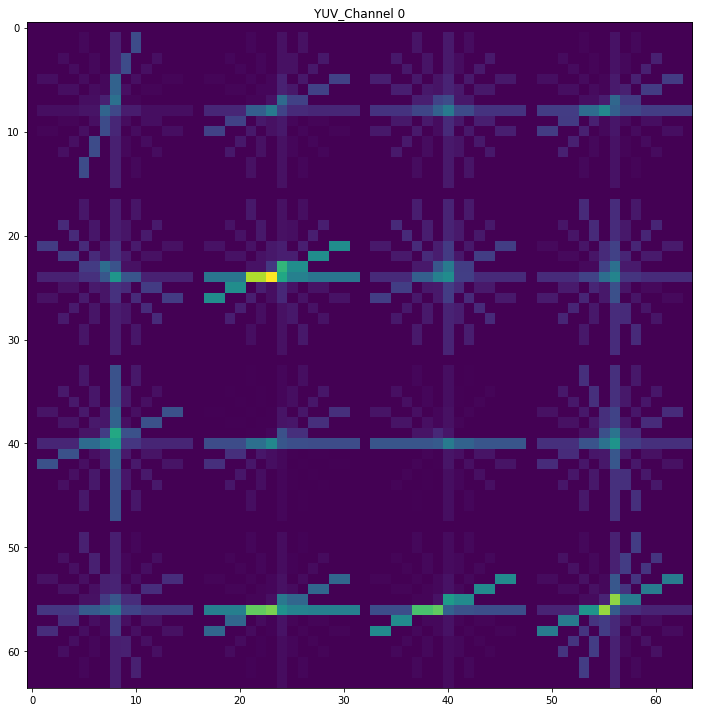

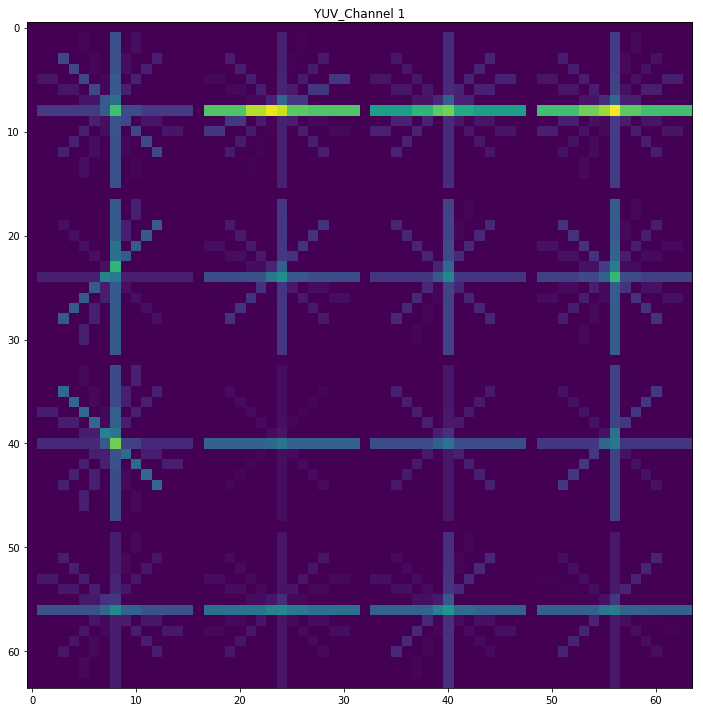

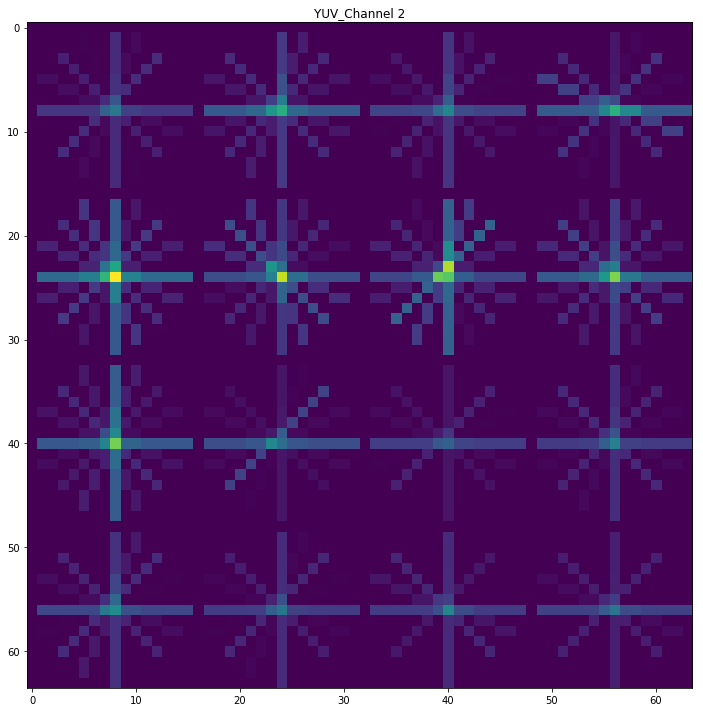

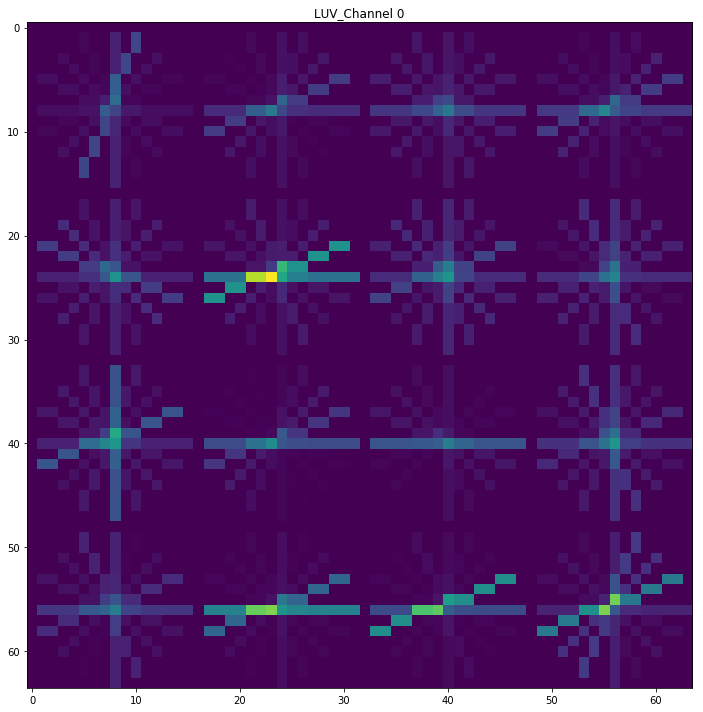

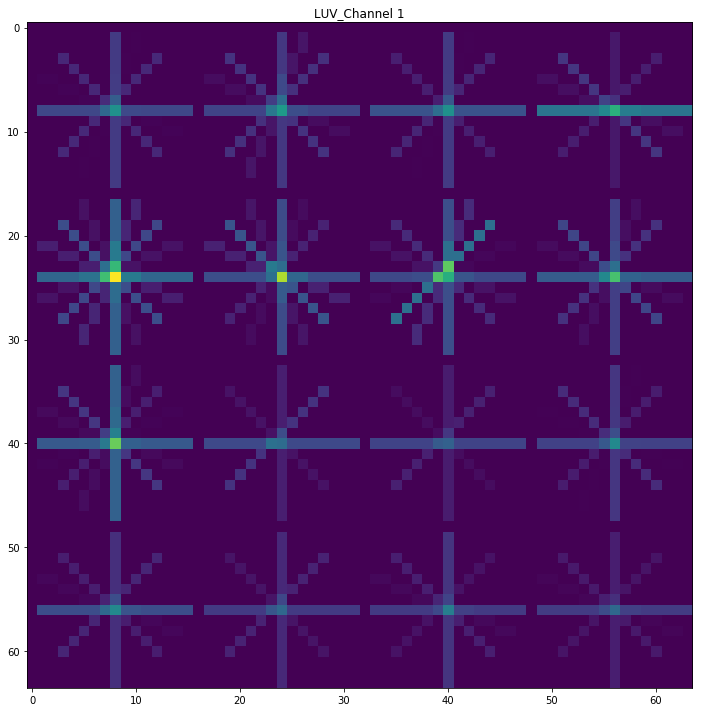

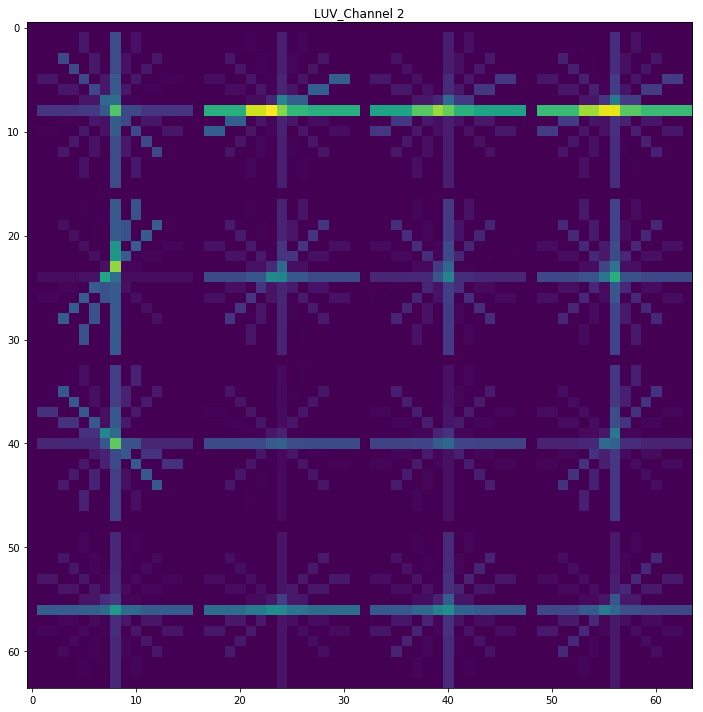

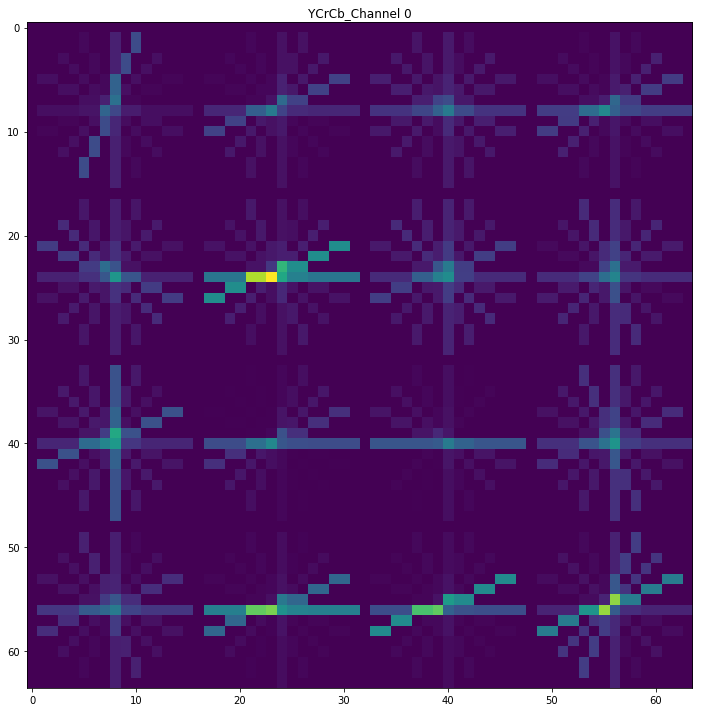

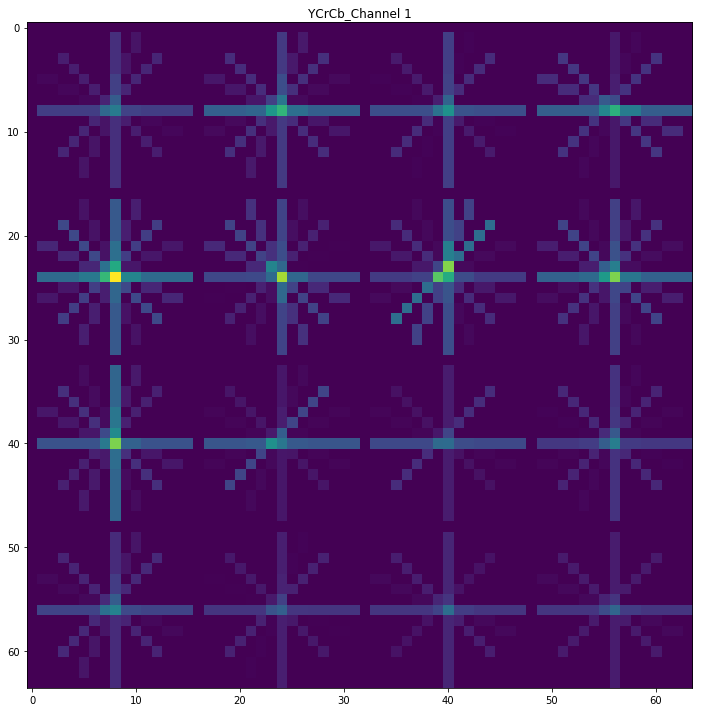

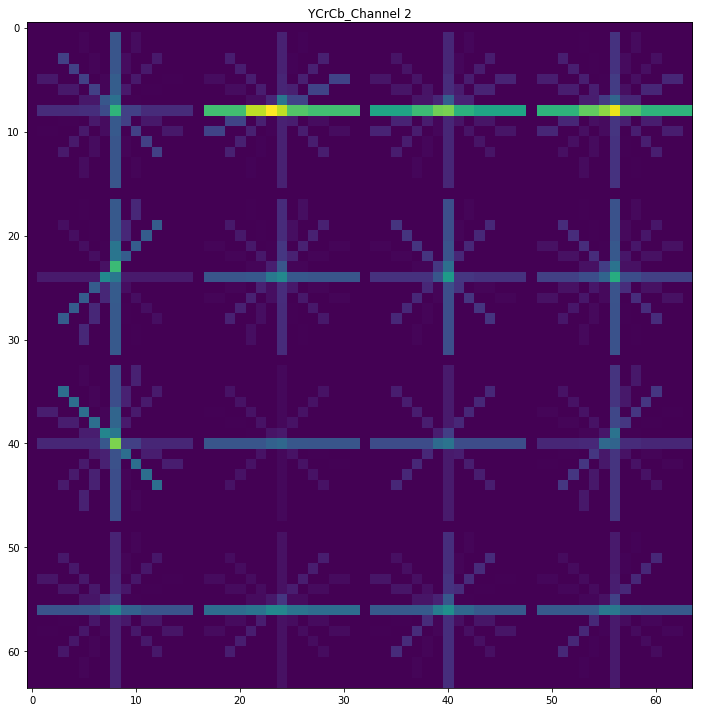

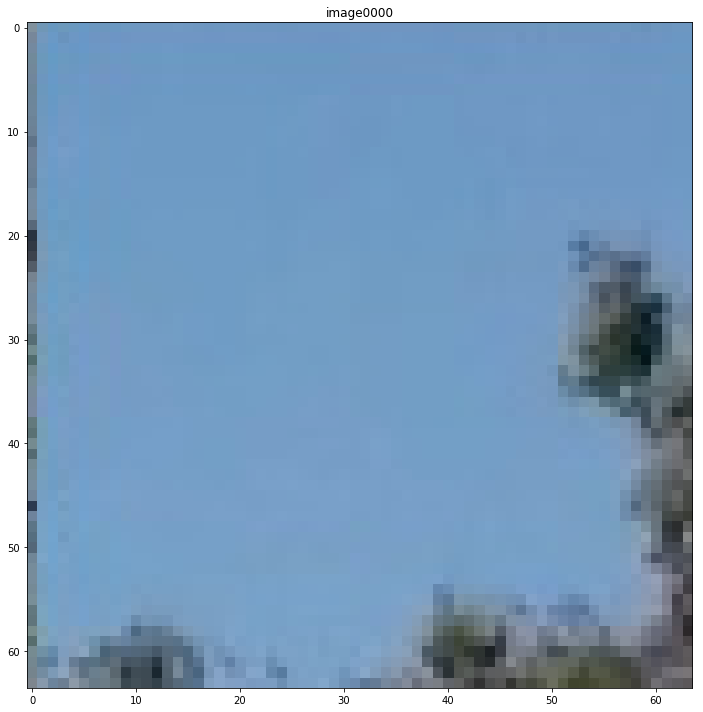

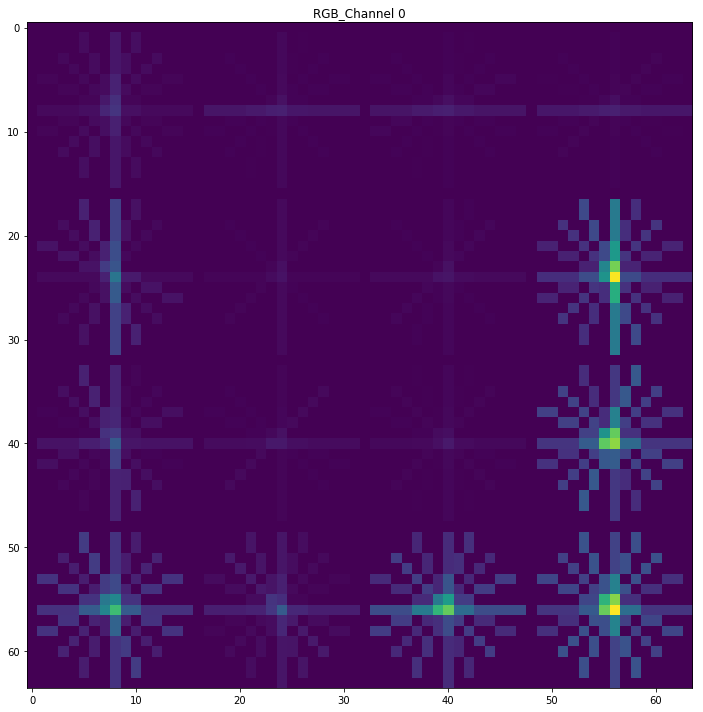

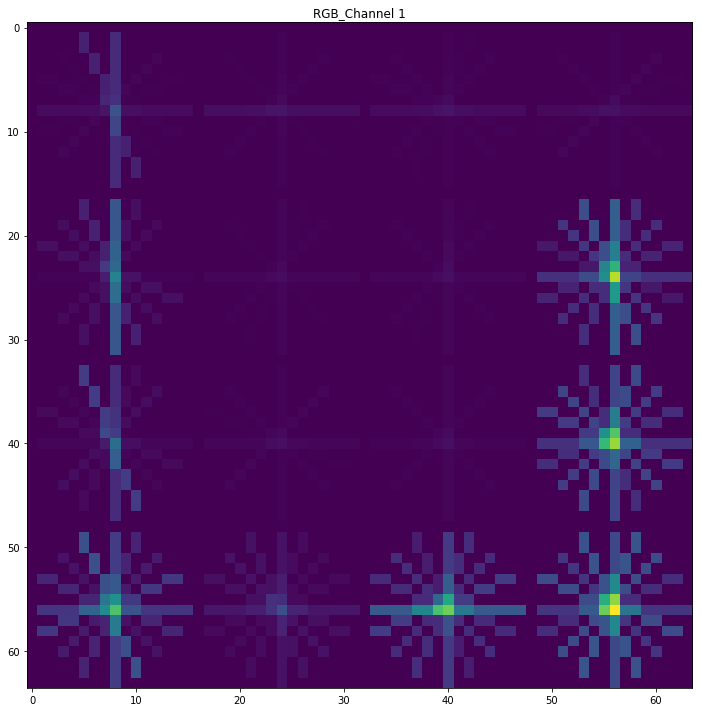

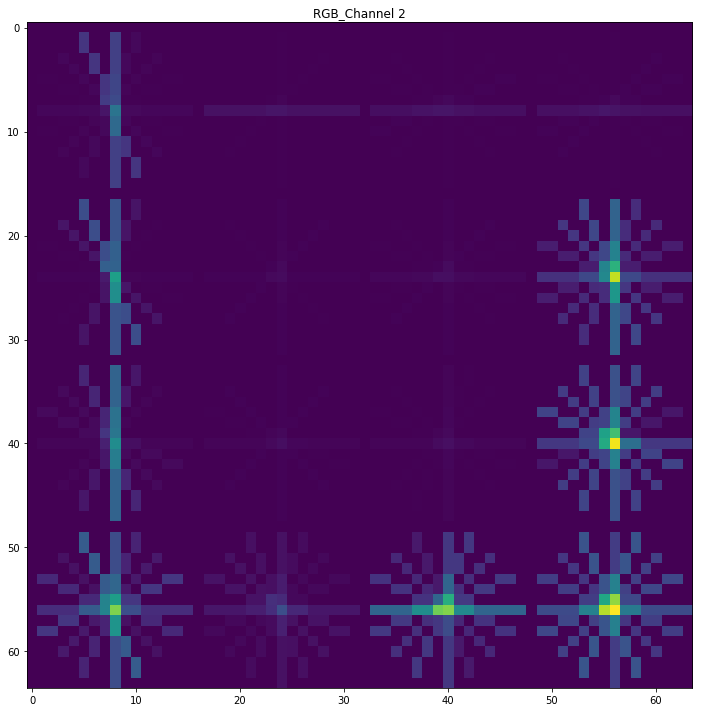

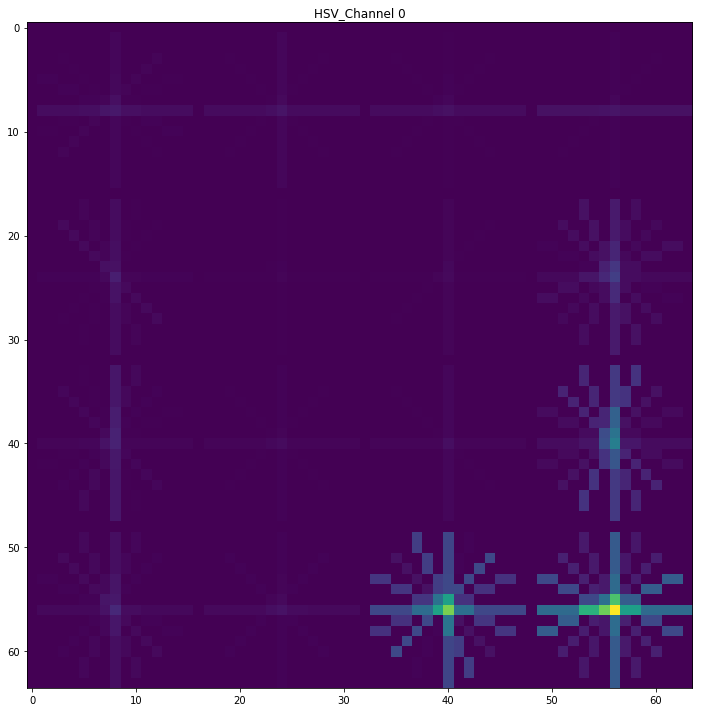

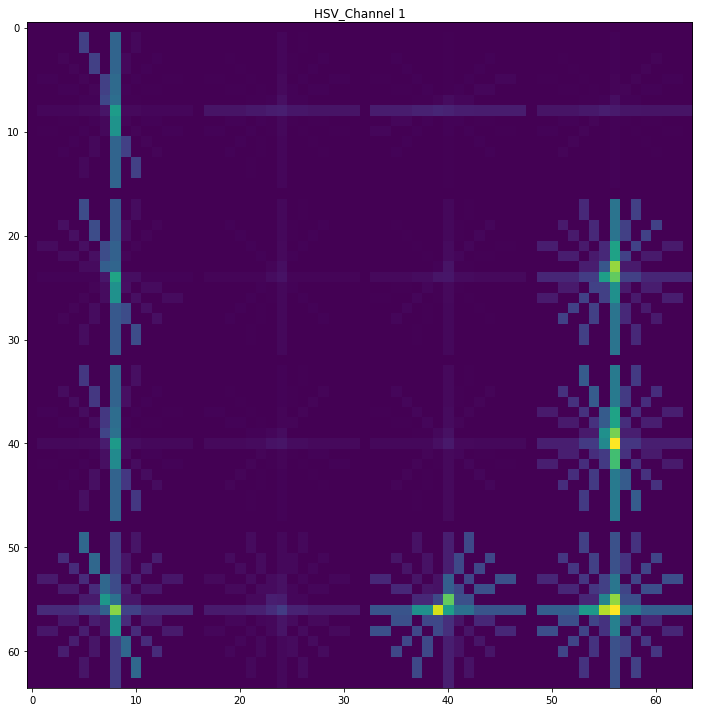

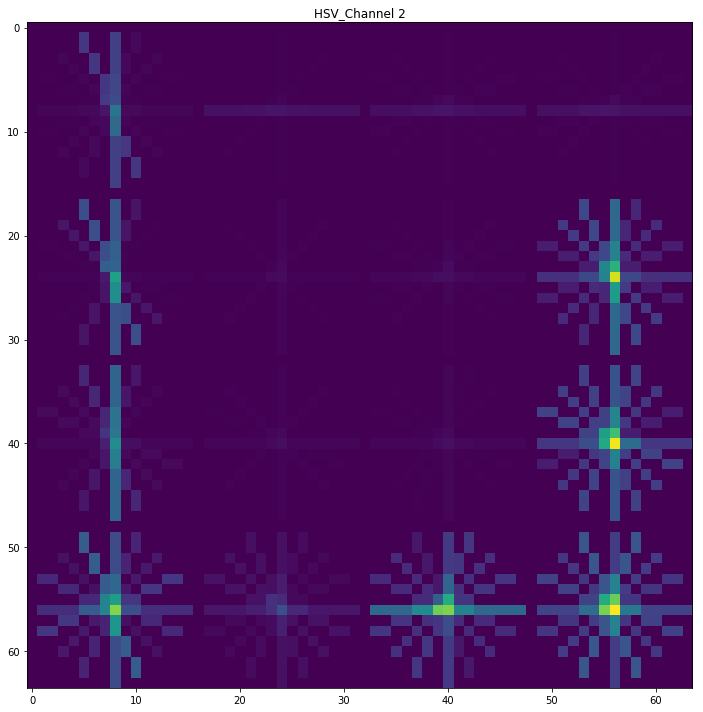

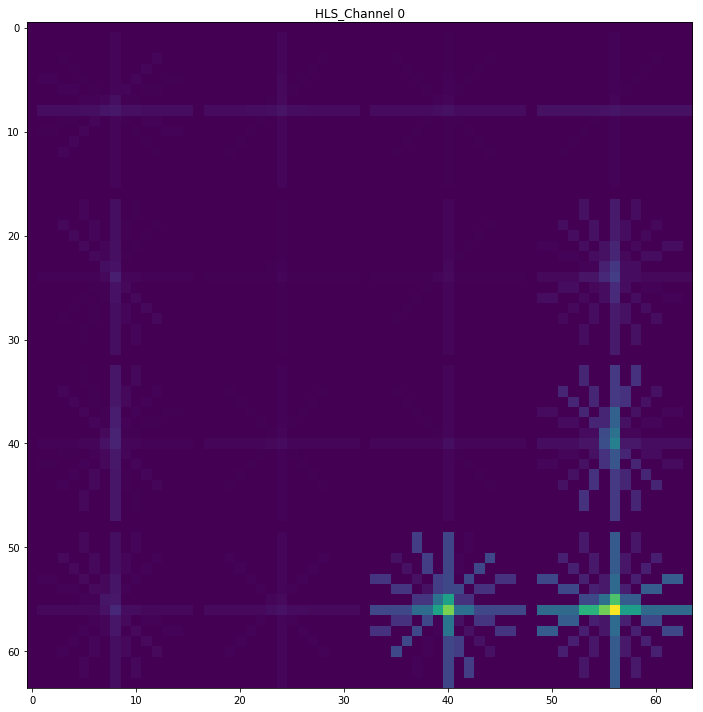

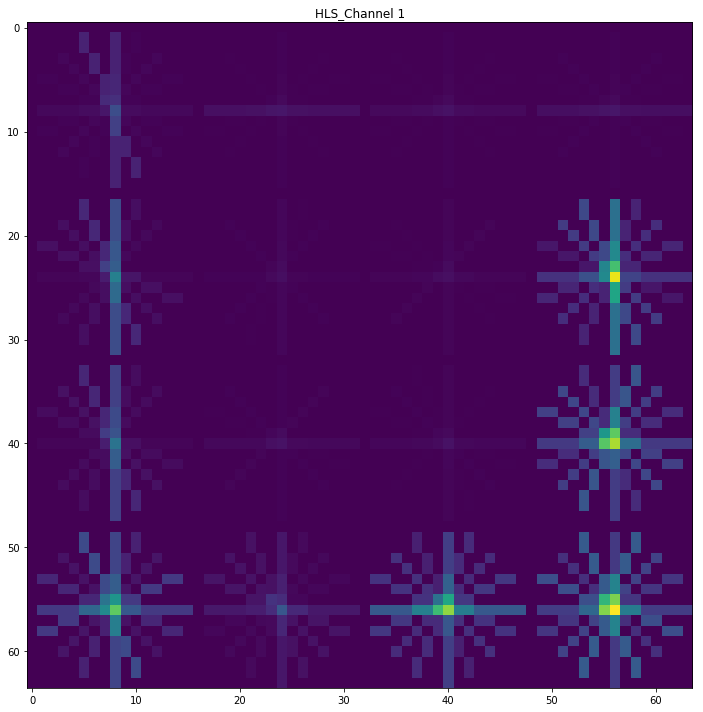

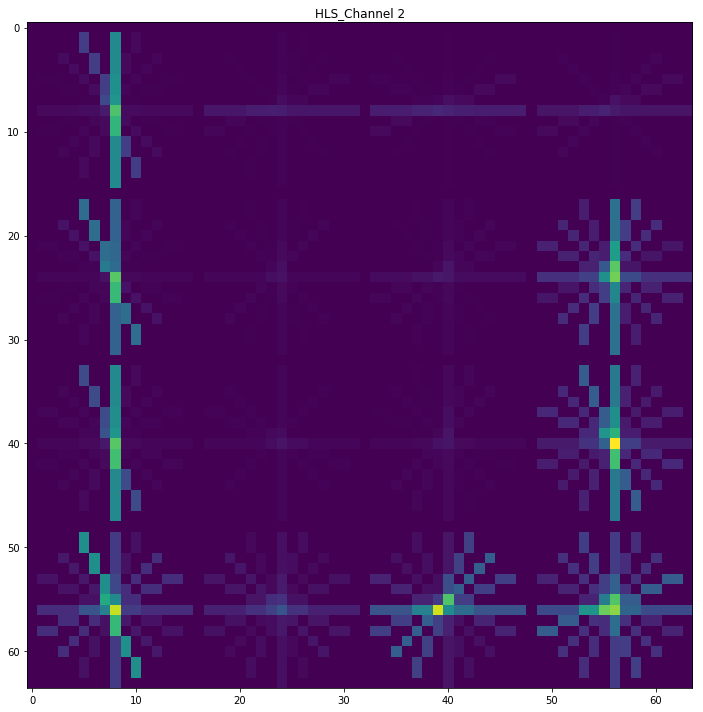

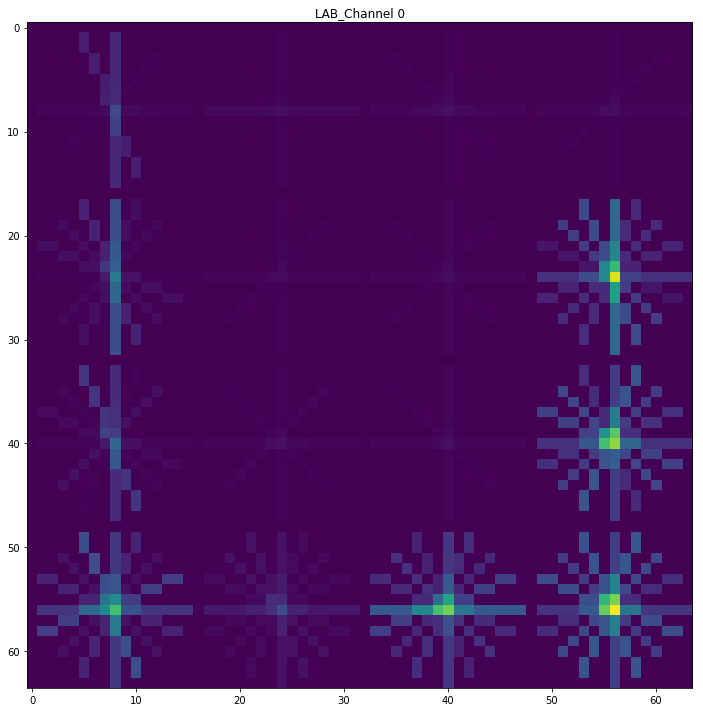

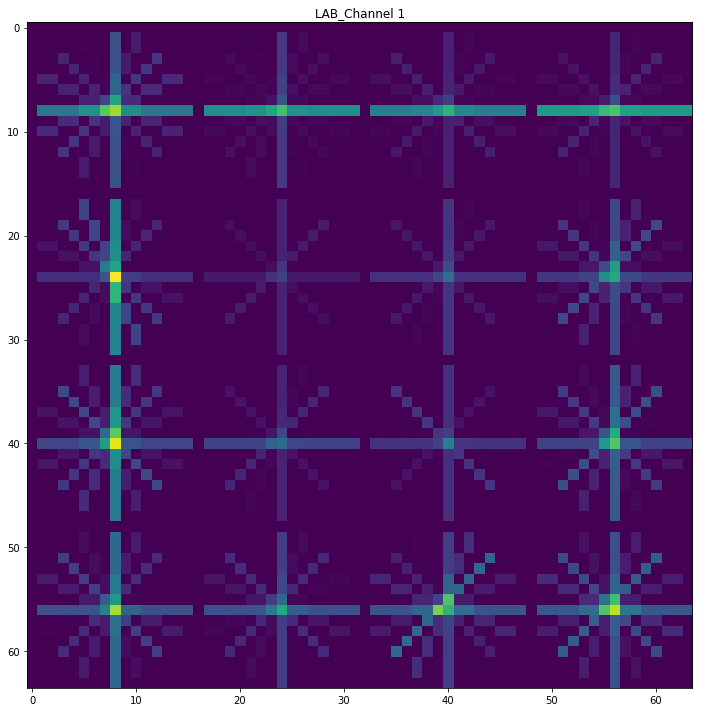

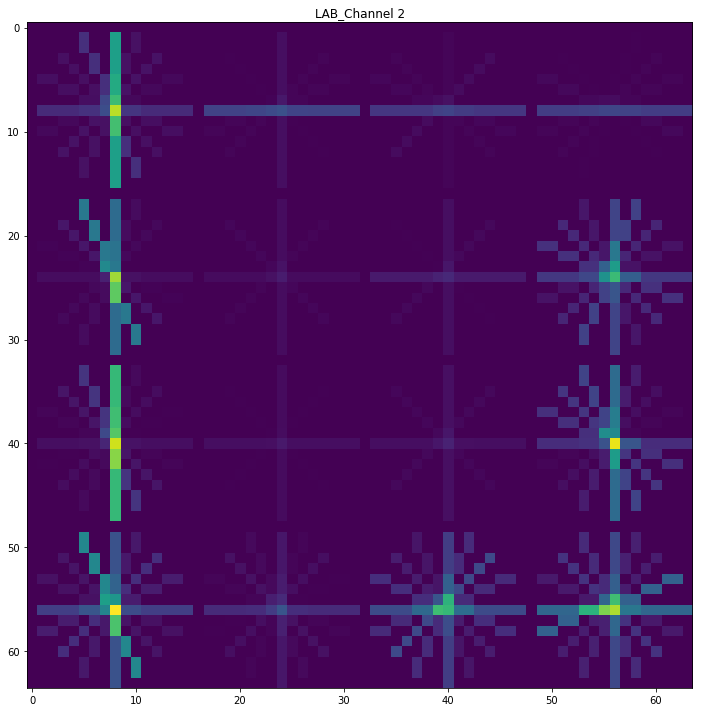

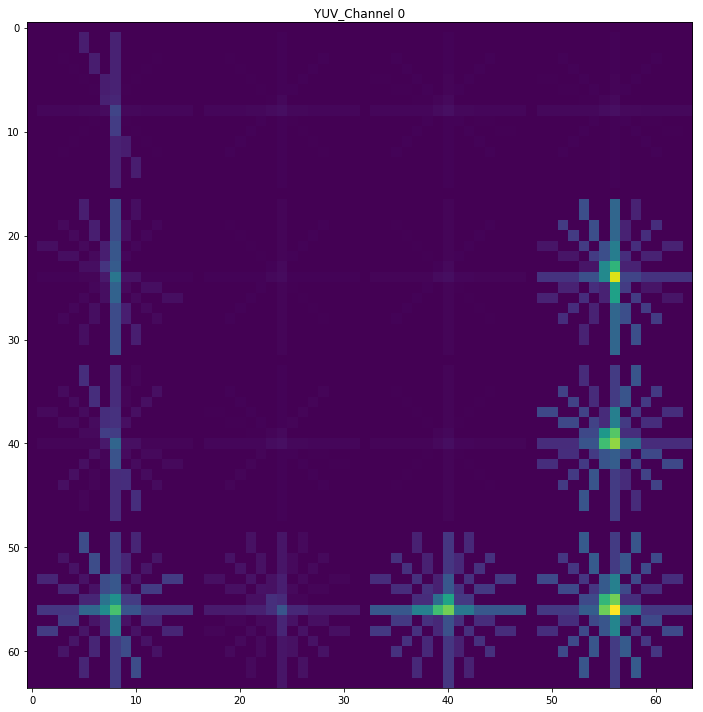

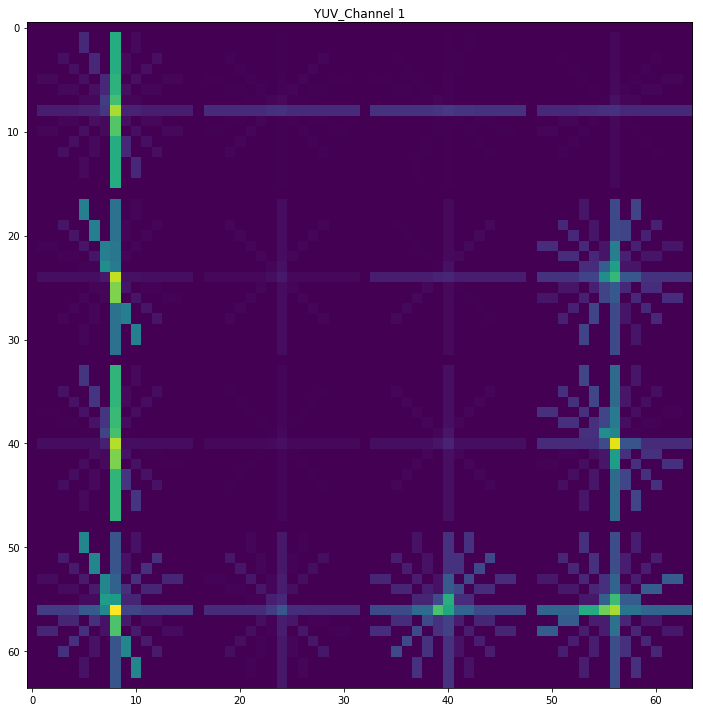

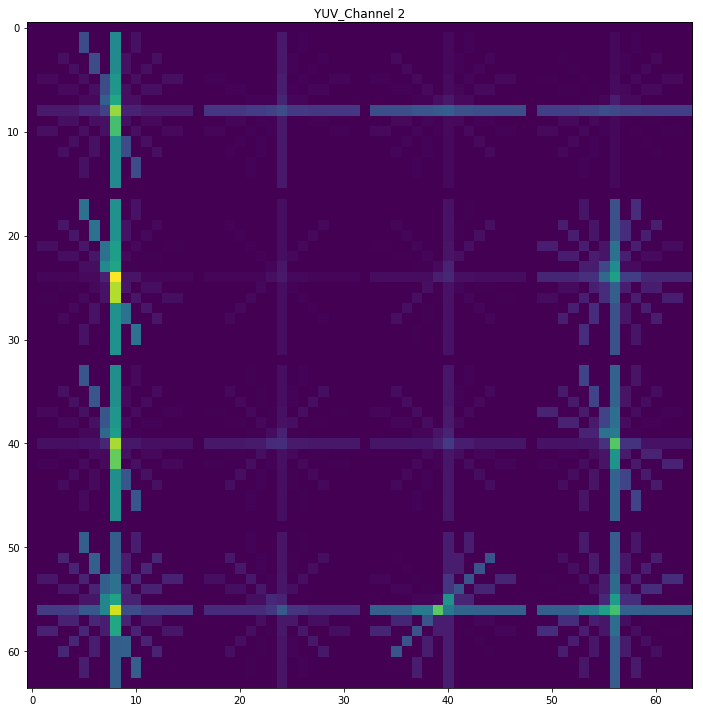

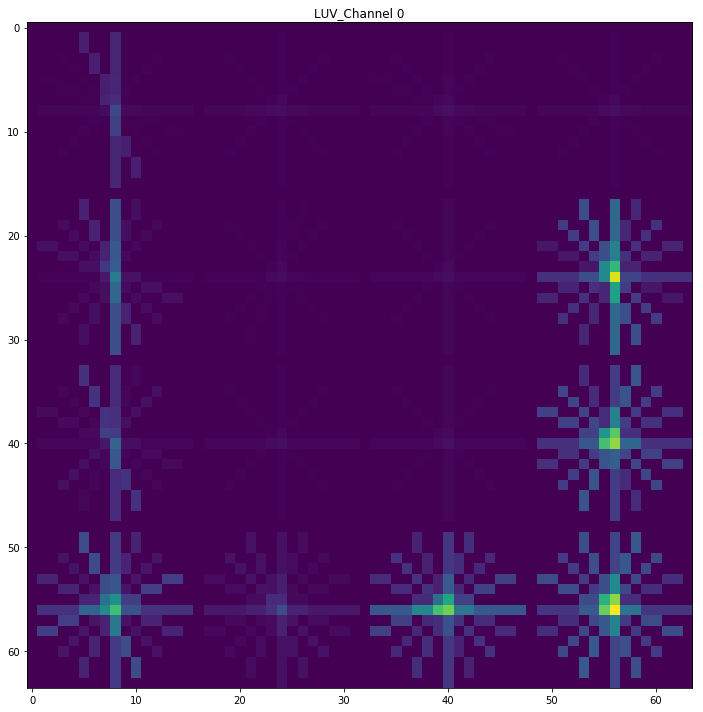

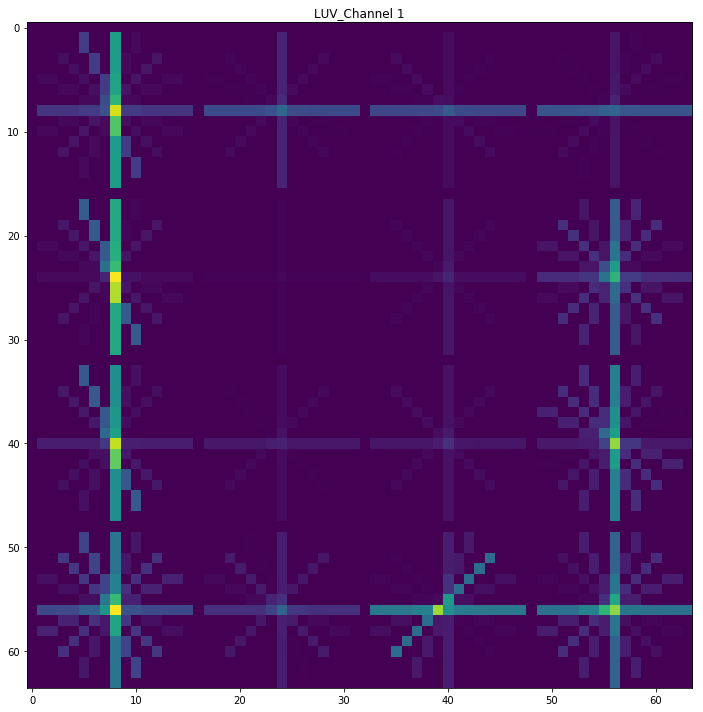

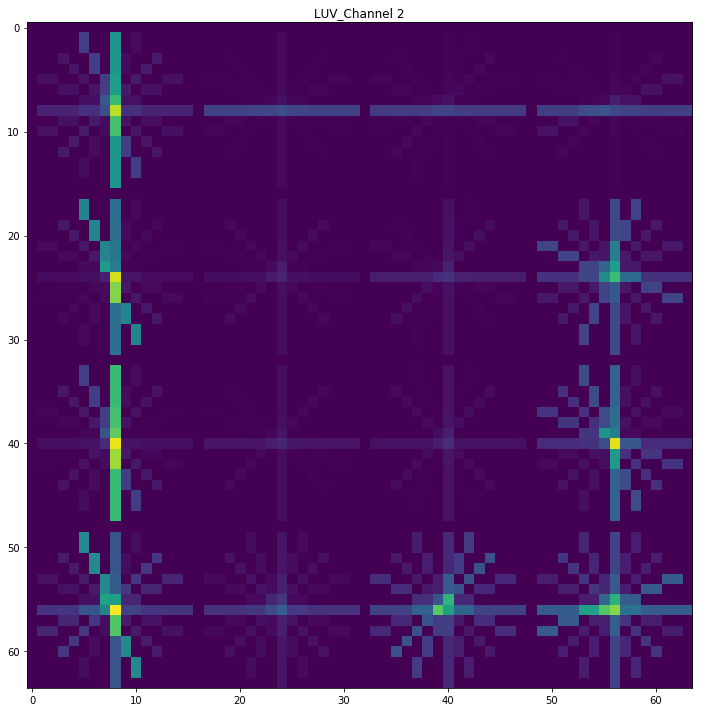

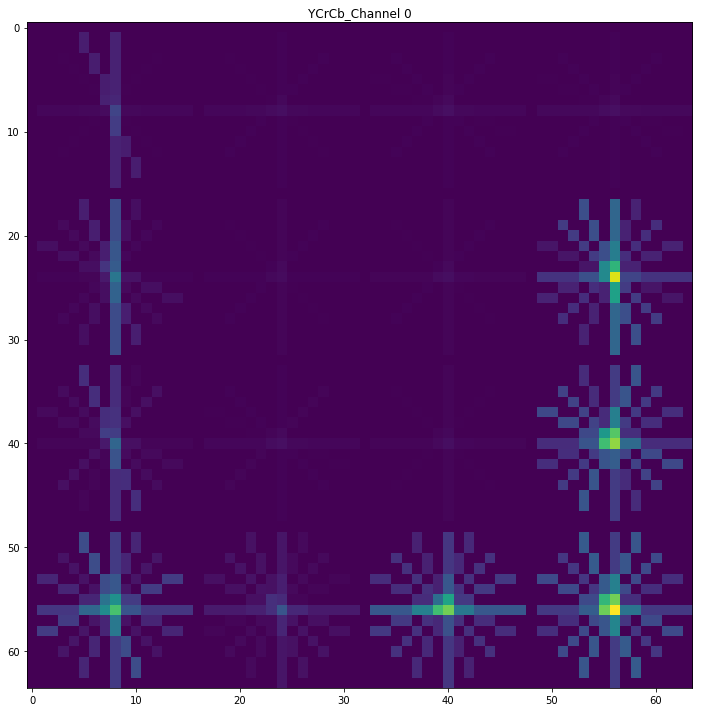

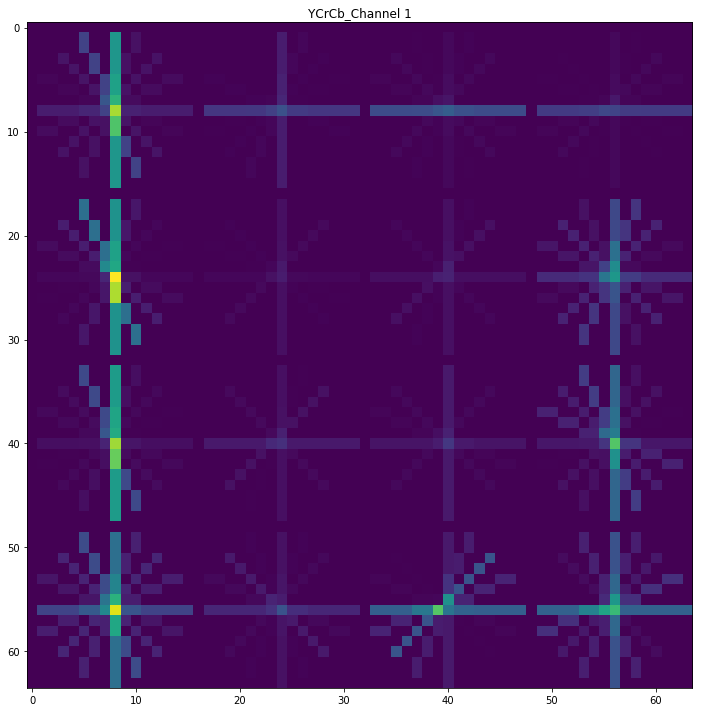

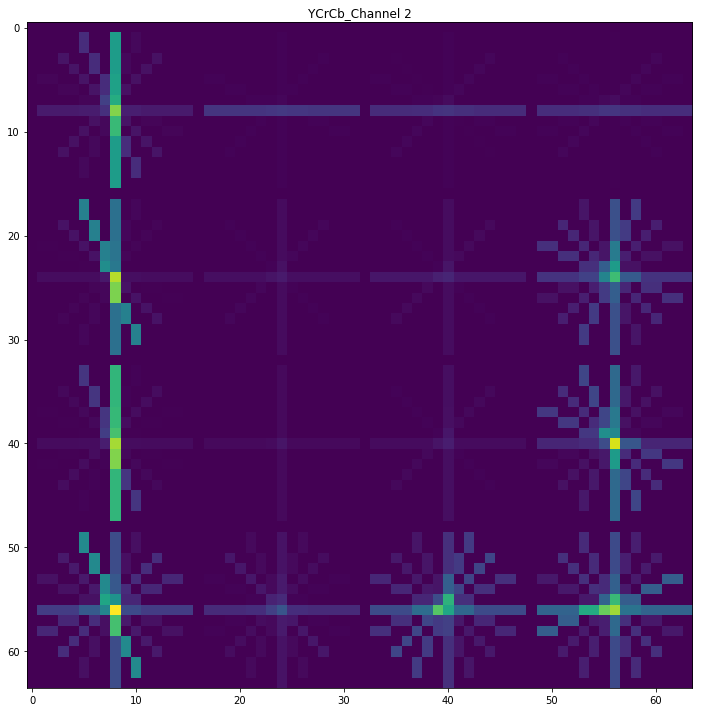

In [19]:
CarImageIndex = 0
#CarImageIndex = randint(0, len(CarImageSet))
HOGCarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGCarImage, HOGCarImageLabel, 1, 1)
ExploreHOGSpace(HOGCarImage[0])

NonCarImageIndex = 0
#NonCarImageIndex = randint(0, len(NonCarImageSet))
HOGNonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGNonCarImage, HOGCarImageLabel, 1, 1)
ExploreHOGSpace(HOGNonCarImage[0])